## Learned Reconstruction

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset.

We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned Primal-Dual reconstruction

and we also compare to a simple FBP-based reconstruction, the results should be approximately

| Method                 |   Error  |
|:-----------------------|:--------:|
| FBP                    | 0.1510   |
| Fully learned          | 0.0240   |
| FBP + learned denoiser | 0.0197   |
| Learned Primal-Dual    | 0.0151   |



# Download dependencies

This commands installs all the needed dependencies if you have the absolute latest version of CUDA (version 9.0) and CuDNN 7.0. On the server provided for the course participants, this is the case. Otherwise `pip install tensorflow-gpu`  (for GPU) or `pip install tensorflow` (for CPU) should be enough.

In [ ]:
! conda install nomkl numpy scipy matplotlib pytest -y
! pip install https://github.com/odlgroup/odl/archive/master.zip
! pip install https://raw.githubusercontent.com/lakshayg/tensorflow-build/master/tensorflow-1.4.0rc1-cp36-cp36m-linux_x86_64.whl
! conda install -c astra-toolbox astra-toolbox -y

# Import dependencies

This should run without errors if all dependencies are installed properly.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import odl
import odl.contrib.tensorflow
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
# Start a tensorflow session
session = tf.InteractiveSession()

# Set the random seed to enable reproducible code
np.random.seed(0)

# Create operators using ODL

Here we create the needed operators in ODL as usual, we then convert them to tensorflow-compatible functions using the `odl.contrib.tensorflow.as_tensorflow_layer` function.

In [3]:
# Create ODL data structures
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28],
                          dtype='float32')

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
operator = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(operator)

# Create tensorflow wrappers
tf_op = odl.contrib.tensorflow.as_tensorflow_layer(operator)
tf_op_adj = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint)
tf_fbp_op = odl.contrib.tensorflow.as_tensorflow_layer(fbp_op)

# Get data and utilities

We now need to get the data we will use, which in this case is the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a set of digits 70000 hand-written digits, of which 60000 are used for training and 10000 for testing.

In addition to this, we create a utility `generate_data` which generates sinograms for each digit, as well as a function `evaluate(...)` that we will use to evaluate how good a reconstruction is and `visualize(...)` which shows an example reconstruction.

In [4]:
# Get MNIST data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [5]:
def generate_data(images):
    """Generate data from images
    
    Parameters
    ----------
    images : np.array of shape [Batch, 28, 28, 1]
        The images (in reconstruction space) which we should create data for.
        
    Returns
    -------
    sinograms : np.array of shape [Batch, 5, 41, 1]
        Noisy sinograms corresponding to ``images``
    """
    data = [operator(image.squeeze()).asarray() +
            np.random.randn(*operator.range.shape) for image in images]
    return np.array(data)[..., None]

In [6]:
# Read the first 1000 mnist test points
batch = mnist.test.next_batch(1000)
test_images = batch[0].reshape([-1, 28, 28, 1])

# Create test data (persistent to save time)
test_images = test_images
test_data = generate_data(test_images)

def evaluate(result_tensor, data_placeholder):
    """Evaluate a reconstruction method.

    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.

    Returns
    -------
    MSE : float
        Mean squared error of the reconstruction.
    """
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data})

    return np.mean((result - test_images) ** 2)

In [7]:
def visualize(result_tensor, data_placeholder):
    """Visualize the result of a reconstruction.
    
    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.
    """
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data[0:1]})
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(test_images[0:1].squeeze(), clim=[0, 1], cmap='bone')
    ax[0].set_title('truth')
    ax[0].set_axis_off()
    ax[1].imshow(result.squeeze(), clim=[0, 1], cmap='bone')
    ax[1].set_title('reconstruction')
    ax[1].set_axis_off()
    plt.show()

In [8]:
# Create placeholders. Placeholders are needed in tensorflow since tensorflow is a lazy language,
# and hence we first define the computational graph with placeholders as input, and later we evaluate it.
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x_true")
    y = tf.placeholder(tf.float32, shape=[None, *operator.range.shape, 1], name="y")

FBP Mean squared error: 0.151120126247406


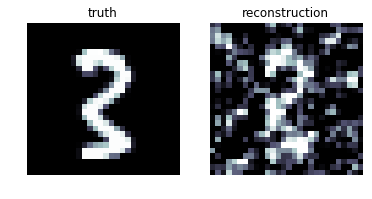

In [9]:
# Use the evaluator on the FBP reconstruction as a baseline
print('FBP Mean squared error: {}'.format(evaluate(tf_fbp_op(y), y)))
visualize(tf_fbp_op(y), y)

# Fully Learned Reconstruction

The most straight-forward example of a learned reconstruction method is the fully-learned reconstruction. In this method, we use a fully-connected neural network to map data to reconstruction, using no information about the forward operator.

In [10]:
with tf.name_scope('fully_learned_reconstruction'):
    x = tf.contrib.layers.flatten(y)

    x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
    x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
    x = tf.contrib.layers.fully_connected(x, num_outputs=28 * 28,
                                          activation_fn=None)

    x_result_fully = tf.reshape(x, [-1, 28, 28, 1])

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x_result_fully - x_true) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

for i in range(10000):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    if i % 100 == 0:
        print('{} Mean squared error: {}'.format(
                i, evaluate(x_result_fully, y)))

0 Mean squared error: 0.5953527688980103
100 Mean squared error: 0.05861716344952583
200 Mean squared error: 0.045941390097141266
300 Mean squared error: 0.040254682302474976
400 Mean squared error: 0.037129614502191544
500 Mean squared error: 0.03498728200793266
600 Mean squared error: 0.03431195393204689
700 Mean squared error: 0.03212343156337738
800 Mean squared error: 0.03226018324494362
900 Mean squared error: 0.03140461817383766
1000 Mean squared error: 0.030884969979524612
1100 Mean squared error: 0.031200217083096504
1200 Mean squared error: 0.030378911644220352
1300 Mean squared error: 0.029830843210220337
1400 Mean squared error: 0.028864746913313866
1500 Mean squared error: 0.02912098355591297
1600 Mean squared error: 0.02908375859260559
1700 Mean squared error: 0.029261965304613113
1800 Mean squared error: 0.02772187814116478
1900 Mean squared error: 0.02794860303401947
2000 Mean squared error: 0.02769533544778824
2100 Mean squared error: 0.027971796691417694
2200 Mean squ

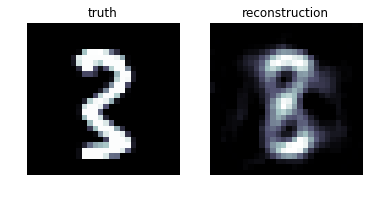

In [11]:
visualize(x_result_fully, y)

# FBP + Learned denoiser

A more efficient method is to first compute some initial reconstruction (here, a filtered back-projection) and then learn how to improve that reconstruction. By doing this, we only need to learn in image space and can thus use very strong tools from machine learning, including convolutional neural networks.

In [12]:
with tf.name_scope('learned_denoiser'):
    x = tf_fbp_op(y)

    x = tf.contrib.layers.conv2d(x, num_outputs=32, kernel_size=3)
    x = tf.contrib.layers.conv2d(x, num_outputs=32, kernel_size=3)
    x = tf.contrib.layers.conv2d(x, num_outputs=1, kernel_size=1,
                                 activation_fn=None)

    x_result_denoise = x

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x_result_denoise - x_true) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

for i in range(10000):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    if i % 100 == 0:
        print('{} Mean squared error: {}'.format(
                i, evaluate(x_result_denoise, y)))

0 Mean squared error: 0.1355559080839157
100 Mean squared error: 0.02441990189254284
200 Mean squared error: 0.023730481043457985
300 Mean squared error: 0.02282790094614029
400 Mean squared error: 0.02228088304400444
500 Mean squared error: 0.021786922588944435
600 Mean squared error: 0.02128434181213379
700 Mean squared error: 0.020961469039320946
800 Mean squared error: 0.02064932882785797
900 Mean squared error: 0.020613348111510277
1000 Mean squared error: 0.020486745983362198
1100 Mean squared error: 0.020675161853432655
1200 Mean squared error: 0.02013031207025051
1300 Mean squared error: 0.0201070886105299
1400 Mean squared error: 0.020035792142152786
1500 Mean squared error: 0.020014464855194092
1600 Mean squared error: 0.01993253454566002
1700 Mean squared error: 0.020192602649331093
1800 Mean squared error: 0.019910408183932304
1900 Mean squared error: 0.01998896896839142
2000 Mean squared error: 0.019928673282265663
2100 Mean squared error: 0.019890468567609787
2200 Mean sq

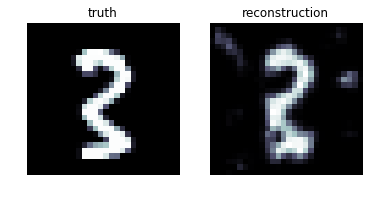

In [13]:
visualize(x_result_denoise, y)

# Learned Primal-Dual

In Learned Primal-Dual reconstruction, we embed the forward operator into a neural network and use it as a component in the neural network. By doing so, we can learn in both reconstruction and in data space, and we can use convolutional networks in both of them.

In [14]:
with tf.name_scope('learned_primal_dual'):
    primal = tf_fbp_op(y)
    dual = tf.identity(y)
    
    for i in range(1):
        dy = tf.concat([dual, tf_op(primal)], axis=-1)
        dy = tf.contrib.layers.conv2d(dy, num_outputs=32, kernel_size=3)
        dy = tf.contrib.layers.conv2d(dy, num_outputs=1, kernel_size=3,
                                      activation_fn=None)
        dual = dual + dy

        dx = tf.concat([primal, tf_op_adj(dual)], axis=-1)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=3,
                                      activation_fn=None)
        primal = primal + dx
    
    x_result_lpd = primal

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x_result_lpd - x_true) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

for i in range(10000):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    if i % 100 == 0:
        print('{} Mean squared error: {}'.format(
                i, evaluate(x_result_lpd, y)))

0 Mean squared error: 9.938268661499023
100 Mean squared error: 0.06742943823337555
200 Mean squared error: 0.05295763537287712
300 Mean squared error: 0.047365907579660416
400 Mean squared error: 0.043527837842702866
500 Mean squared error: 0.04096687212586403
600 Mean squared error: 0.03813368082046509
700 Mean squared error: 0.03569275513291359
800 Mean squared error: 0.03316299244761467
900 Mean squared error: 0.031654682010412216
1000 Mean squared error: 0.031051138415932655
1100 Mean squared error: 0.029832402244210243
1200 Mean squared error: 0.02908938378095627
1300 Mean squared error: 0.02846803516149521
1400 Mean squared error: 0.028568124398589134
1500 Mean squared error: 0.02913379669189453
1600 Mean squared error: 0.028141804039478302
1700 Mean squared error: 0.026834353804588318
1800 Mean squared error: 0.028223246335983276
1900 Mean squared error: 0.026741208508610725
2000 Mean squared error: 0.025722945109009743
2100 Mean squared error: 0.02563689835369587
2200 Mean squ

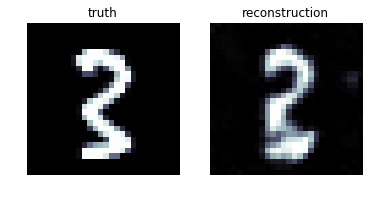

In [15]:
visualize(x_result_lpd, y)